# OLS Regression Model - Statistical Analysis and Interpretation

## Strategy:
- Focus on statistical interpretation and business meaning
- Comprehensive OLS diagnostics with clear explanations
- Test meaningful feature combinations based on preprocessing insights
- Emphasize coefficient interpretation for power plant operations

In [ ]:
# Load preprocessing results from preprocessing.ipynb
%run preprocessing.ipynb
print("Preprocessing complete. Data ready for OLS modeling.")
print(f"Loaded variables: data, features, target, X_standardized")
print(f"Data shape: {data.shape}")
print(f"Features: {features}")
print(f"Target: {target}")

In [53]:
# PHASE 1: ASSUMPTION TESTING & DIAGNOSTICS
# ============================================
# Rigorous statistical validation before model fitting

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("PHASE 1: COMPREHENSIVE OLS ASSUMPTION TESTING")
print("=" * 50)

# Prepare data for analysis
X = data[features]
y = data[target]

# Train-test split for validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

# Use standardized features (essential for condition number analysis)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)

print(f"Training set: {X_train_scaled.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print("\n1. LINEARITY ASSUMPTION TESTING")
print("-" * 30)

# Test 1: RESET Test for Functional Form
print("RESET Test for Functional Form Specification:")
print("H0: Linear functional form is adequate")
print("H1: Non-linear terms are needed")

# Fit basic linear model for RESET test
X_with_const = sm.add_constant(X_train_scaled)
model_basic = sm.OLS(y_train, X_with_const).fit()

# Manual RESET test using fitted values
y_fitted = model_basic.fittedvalues
y_fitted_sq = y_fitted ** 2
y_fitted_cube = y_fitted ** 3

# Augmented regression with powers of fitted values
X_reset = X_with_const.copy()
X_reset['fitted_sq'] = y_fitted_sq
X_reset['fitted_cube'] = y_fitted_cube

model_reset = sm.OLS(y_train, X_reset).fit()

# F-test for additional terms
f_stat = ((model_reset.ssr - model_basic.ssr) / 2) / (model_basic.ssr / (len(y_train) - len(features) - 1))
f_pvalue = 1 - stats.f.cdf(f_stat, 2, len(y_train) - len(features) - 3)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {f_pvalue:.4f}")
print(f"Result: {'REJECT H0 - Non-linearity detected' if f_pvalue < 0.05 else 'FAIL TO REJECT H0 - Linear form adequate'}")

print(f"\n2. MULTICOLLINEARITY DIAGNOSTICS")
print("-" * 30)

# Calculate VIF for all features
print("Variance Inflation Factors (VIF):")
print("Interpretation: VIF > 5 indicates problematic multicollinearity")
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) 
                   for i in range(len(X_train_scaled.columns))]

for _, row in vif_data.iterrows():
    status = "PROBLEMATIC" if row['VIF'] > 5 else "ACCEPTABLE" if row['VIF'] > 2 else "EXCELLENT"
    print(f"{row['Feature']:20s}: {row['VIF']:6.2f} ({status})")

# Condition Number Analysis
print(f"\nCondition Number Analysis:")
cond_num = np.linalg.cond(X_with_const)
print(f"Condition Number: {cond_num:.2f}")
print(f"Interpretation: {('EXCELLENT' if cond_num < 10 else 'GOOD' if cond_num < 30 else 'PROBLEMATIC')} numerical stability")

# Eigenvalue analysis
eigenvals = np.linalg.eigvals(X_train_scaled.corr())
print(f"Smallest eigenvalue: {eigenvals.min():.6f}")
print(f"Eigenvalue ratio: {eigenvals.max()/eigenvals.min():.2f}")

print(f"\n3. RESIDUAL NORMALITY TESTING")
print("-" * 30)

# Note: We test RESIDUAL normality, not predictor normality
residuals = model_basic.resid

# Jarque-Bera test - use scipy version which returns 2 values
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print("Jarque-Bera Test for Residual Normality:")
print("H0: Residuals are normally distributed")
print(f"Test statistic: {jb_stat:.4f}")
print(f"p-value: {jb_pvalue:.4f}")
print(f"Result: {'REJECT H0 - Non-normal residuals' if jb_pvalue < 0.05 else 'FAIL TO REJECT H0 - Normal residuals'}")

# Shapiro-Wilk test (more powerful for small samples)
if len(residuals) <= 5000:
    sw_stat, sw_pvalue = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Test:")
    print(f"Test statistic: {sw_stat:.4f}")
    print(f"p-value: {sw_pvalue:.4f}")
    print(f"Result: {'REJECT H0 - Non-normal residuals' if sw_pvalue < 0.05 else 'FAIL TO REJECT H0 - Normal residuals'}")

print(f"\n4. HETEROSCEDASTICITY TESTING")
print("-" * 30)

# Breusch-Pagan test
bp_stat, bp_pvalue, f_stat_bp, f_pvalue_bp = het_breuschpagan(residuals, X_with_const)
print("Breusch-Pagan Test for Heteroscedasticity:")
print("H0: Homoscedasticity (constant variance)")
print("H1: Heteroscedasticity (non-constant variance)")
print(f"LM statistic: {bp_stat:.4f}")
print(f"p-value: {bp_pvalue:.4f}")
print(f"Result: {'REJECT H0 - Heteroscedasticity detected' if bp_pvalue < 0.05 else 'FAIL TO REJECT H0 - Homoscedasticity'}")

# White test (more general)
white_stat, white_pvalue, white_f, white_f_pvalue = het_white(residuals, X_with_const)
print(f"\nWhite Test for Heteroscedasticity:")
print(f"LM statistic: {white_stat:.4f}")
print(f"p-value: {white_pvalue:.4f}")
print(f"Result: {'REJECT H0 - Heteroscedasticity detected' if white_pvalue < 0.05 else 'FAIL TO REJECT H0 - Homoscedasticity'}")

print(f"\n5. AUTOCORRELATION TESTING")
print("-" * 30)

# Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("Durbin-Watson Test for Autocorrelation:")
print("H0: No autocorrelation (independent residuals)")
print(f"DW statistic: {dw_stat:.4f}")
print("Interpretation:")
if dw_stat < 1.5:
    print("- Strong positive autocorrelation detected")
elif dw_stat > 2.5:
    print("- Strong negative autocorrelation detected")  
else:
    print("- No significant autocorrelation")

print(f"\nCRITICAL INSIGHT:")
print("=" * 15)
print("• Non-normal PREDICTORS are expected in industrial data")
print("• Non-normal RESIDUALS indicate model misspecification")
print("• High VIF means individual coefficients are unreliable")
print("• Focus on model combinations that pass diagnostic tests")

PHASE 1: COMPREHENSIVE OLS ASSUMPTION TESTING
Training set: 7621 samples
Test set: 1906 samples

1. LINEARITY ASSUMPTION TESTING
------------------------------
RESET Test for Functional Form Specification:
H0: Linear functional form is adequate
H1: Non-linear terms are needed
F-statistic: -376.5740
p-value: 1.0000
Result: FAIL TO REJECT H0 - Linear form adequate

2. MULTICOLLINEARITY DIAGNOSTICS
------------------------------
Variance Inflation Factors (VIF):
Interpretation: VIF > 5 indicates problematic multicollinearity
ambient_temp        :   5.89 (PROBLEMATIC)
vacuum              :   3.87 (ACCEPTABLE)
ambient_pressure    :   1.46 (EXCELLENT)
relative_humidity   :   1.71 (EXCELLENT)

Condition Number Analysis:
Condition Number: 4.83
Interpretation: EXCELLENT numerical stability
Smallest eigenvalue: 0.104216
Eigenvalue ratio: 23.32

3. RESIDUAL NORMALITY TESTING
------------------------------
Jarque-Bera Test for Residual Normality:
H0: Residuals are normally distributed
Test statist

In [54]:
# PHASE 2: COMPREHENSIVE MODEL ANALYSIS - ALL COMBINATIONS
# =========================================================
# Test all 15 possible variable combinations systematically

from itertools import combinations
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

print("PHASE 2: SYSTEMATIC ALL-COMBINATIONS ANALYSIS")
print("=" * 50)

# Generate all possible combinations (1 to 4 variables)
all_combinations = []
for r in range(1, len(features) + 1):
    for combo in combinations(features, r):
        all_combinations.append(list(combo))

print(f"Testing {len(all_combinations)} variable combinations:")
for i, combo in enumerate(all_combinations, 1):
    print(f"{i:2d}. {combo}")

print(f"\nSystematic Model Evaluation:")
print("=" * 30)

# Store results for comprehensive analysis
results_comprehensive = []

# 10-fold cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for combo_idx, feature_combo in enumerate(all_combinations, 1):
    combo_name = " + ".join(feature_combo)
    
    # Prepare data with individual scaler for this combination
    X_combo = X_train[feature_combo]
    
    # Create individual scaler for this feature combination
    combo_scaler = StandardScaler()
    X_combo_scaled = pd.DataFrame(
        combo_scaler.fit_transform(X_combo), 
        columns=X_combo.columns, 
        index=X_combo.index
    )
    
    X_combo_with_const = sm.add_constant(X_combo_scaled)
    
    # Fit OLS model 
    model = sm.OLS(y_train, X_combo_with_const).fit()
    model_robust = model.get_robustcov_results(cov_type='HC3')  # White standard errors
    
    # Calculate performance metrics
    r2 = model.rsquared
    adj_r2 = model.rsquared_adj
    aic = model.aic
    bic = model.bic
    
    # Test predictions using the same scaler
    X_test_combo = X_test[feature_combo]
    X_test_combo_scaled = pd.DataFrame(
        combo_scaler.transform(X_test_combo), 
        columns=X_test_combo.columns, 
        index=X_test_combo.index
    )
    X_test_combo_with_const = sm.add_constant(X_test_combo_scaled)
    y_pred_test = model.predict(X_test_combo_with_const)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Cross-validation R²
    lr_cv = LinearRegression()
    cv_scores = cross_val_score(lr_cv, X_combo_scaled, y_train, cv=kf, scoring='r2')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # VIF calculation (for models with >1 variable)
    if len(feature_combo) > 1:
        vif_values = [variance_inflation_factor(X_combo_scaled.values, i) for i in range(len(feature_combo))]
        max_vif = max(vif_values)
        mean_vif = np.mean(vif_values)
    else:
        vif_values = [1.0]
        max_vif = 1.0
        mean_vif = 1.0
    
    # Statistical significance using original model (not robust)
    all_significant = all(model.pvalues[1:] < 0.05)  # Exclude intercept
    
    # Extract coefficients using proper indexing
    coefficients = {}
    param_names = X_combo_with_const.columns.tolist()
    
    for i, feature in enumerate(feature_combo):
        if feature in param_names:
            param_idx = param_names.index(feature)
            coef_val = model_robust.params[param_idx]
            coef_se = model_robust.bse[param_idx] 
            coef_pval = model.pvalues[param_idx]  # Use original model for p-values
            coefficients[feature] = {
                'coef': coef_val,
                'se': coef_se,
                'pvalue': coef_pval,
                'significant': coef_pval < 0.05
            }
    
    # Store comprehensive results
    result = {
        'combination_id': combo_idx,
        'features': feature_combo,
        'feature_names': combo_name,
        'n_features': len(feature_combo),
        'r2': r2,
        'adj_r2': adj_r2,
        'test_r2': test_r2,
        'cv_r2_mean': cv_mean,
        'cv_r2_std': cv_std,
        'aic': aic,
        'bic': bic,
        'max_vif': max_vif,
        'mean_vif': mean_vif,
        'all_significant': all_significant,
        'coefficients': coefficients,
        'model_object': model_robust,
        'scaler': combo_scaler  # Store scaler for later use
    }
    
    results_comprehensive.append(result)
    
    # Progress indicator
    print(f"✓ Model {combo_idx:2d}/15: {combo_name:40s} | R²={r2:.4f} | CV={cv_mean:.4f}±{cv_std:.3f}")

# Convert to DataFrame for easy analysis
results_df = pd.DataFrame([{
    'Model': f"M{r['combination_id']:02d}",
    'Features': r['feature_names'],
    'N_Vars': r['n_features'],
    'R²': r['r2'],
    'Adj_R²': r['adj_r2'],
    'Test_R²': r['test_r2'],
    'CV_R²': r['cv_r2_mean'],
    'CV_Std': r['cv_r2_std'],
    'AIC': r['aic'],
    'BIC': r['bic'],
    'Max_VIF': r['max_vif'],
    'All_Sig': r['all_significant']
} for r in results_comprehensive])

print(f"\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Sort by different criteria
print(f"\n1. TOP MODELS BY CROSS-VALIDATION R²:")
print("-" * 40)
top_cv = results_df.nlargest(8, 'CV_R²')[['Model', 'Features', 'CV_R²', 'CV_Std', 'Max_VIF', 'All_Sig']]
for _, row in top_cv.iterrows():
    sig_icon = "✓" if row['All_Sig'] else "✗"
    vif_status = "OK" if row['Max_VIF'] < 5 else "HIGH"
    print(f"{row['Model']}: {row['CV_R²']:.4f}±{row['CV_Std']:.3f} | VIF:{vif_status:4s} | Sig:{sig_icon} | {row['Features']}")

print(f"\n2. BEST MODELS BY MODEL SELECTION CRITERIA:")
print("-" * 45)
best_aic = results_df.loc[results_df['AIC'].idxmin()]
best_bic = results_df.loc[results_df['BIC'].idxmin()]
best_adj_r2 = results_df.loc[results_df['Adj_R²'].idxmax()]

print(f"Best AIC:     {best_aic['Model']} | AIC={best_aic['AIC']:.1f} | {best_aic['Features']}")
print(f"Best BIC:     {best_bic['Model']} | BIC={best_bic['BIC']:.1f} | {best_bic['Features']}")
print(f"Best Adj R²:  {best_adj_r2['Model']} | R²={best_adj_r2['Adj_R²']:.4f} | {best_adj_r2['Features']}")

print(f"\n3. MODELS WITH EXCELLENT STATISTICAL PROPERTIES:")
print("-" * 50)
excellent_models = results_df[(results_df['Max_VIF'] < 3) & (results_df['All_Sig'] == True)]
if len(excellent_models) > 0:
    excellent_sorted = excellent_models.nlargest(5, 'CV_R²')[['Model', 'Features', 'CV_R²', 'Max_VIF']]
    for _, row in excellent_sorted.iterrows():
        print(f"{row['Model']}: {row['CV_R²']:.4f} | VIF={row['Max_VIF']:.2f} | {row['Features']}")
else:
    print("No models found with VIF < 3 and all significant coefficients")

print(f"\n4. PERFORMANCE DEGRADATION ANALYSIS:")
print("-" * 40)
full_model_cv = results_df[results_df['N_Vars'] == 4]['CV_R²'].iloc[0]
for n_vars in [3, 2, 1]:
    best_n = results_df[results_df['N_Vars'] == n_vars].nlargest(1, 'CV_R²').iloc[0]
    degradation = full_model_cv - best_n['CV_R²']
    print(f"Best {n_vars}-var model: {best_n['CV_R²']:.4f} | Loss: {degradation:.4f} | {best_n['Features']}")

PHASE 2: SYSTEMATIC ALL-COMBINATIONS ANALYSIS
Testing 15 variable combinations:
 1. ['ambient_temp']
 2. ['vacuum']
 3. ['ambient_pressure']
 4. ['relative_humidity']
 5. ['ambient_temp', 'vacuum']
 6. ['ambient_temp', 'ambient_pressure']
 7. ['ambient_temp', 'relative_humidity']
 8. ['vacuum', 'ambient_pressure']
 9. ['vacuum', 'relative_humidity']
10. ['ambient_pressure', 'relative_humidity']
11. ['ambient_temp', 'vacuum', 'ambient_pressure']
12. ['ambient_temp', 'vacuum', 'relative_humidity']
13. ['ambient_temp', 'ambient_pressure', 'relative_humidity']
14. ['vacuum', 'ambient_pressure', 'relative_humidity']
15. ['ambient_temp', 'vacuum', 'ambient_pressure', 'relative_humidity']

Systematic Model Evaluation:
✓ Model  1/15: ambient_temp                             | R²=0.8981 | CV=0.8979±0.009
✓ Model  2/15: vacuum                                   | R²=0.7530 | CV=0.7522±0.017
✓ Model  3/15: ambient_pressure                         | R²=0.2698 | CV=0.2680±0.027
✓ Model  4/15: relati

In [55]:
# PHASE 3: VARIANCE DECOMPOSITION & EFFECT ATTRIBUTION
# ====================================================
# Decompose R² into unique and shared variance components

from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns

print("PHASE 3: VARIANCE DECOMPOSITION ANALYSIS")
print("=" * 50)

# Extract R² values for all combinations for commonality analysis
r2_dict = {}
for result in results_comprehensive:
    feature_key = tuple(sorted(result['features']))
    r2_dict[feature_key] = result['r2']

# Individual variable R²
r2_individual = {}
for feature in features:
    r2_individual[feature] = r2_dict[(feature,)]

print("1. INDIVIDUAL VARIABLE CONTRIBUTIONS:")
print("-" * 40)
for feature in features:
    r2_val = r2_individual[feature]
    print(f"{feature:20s}: R² = {r2_val:.4f} ({r2_val*100:.1f}%)")

# Pairwise combinations and their R²
print(f"\n2. PAIRWISE COMBINATIONS:")
print("-" * 40)
r2_pairs = {}
for result in results_comprehensive:
    if len(result['features']) == 2:
        pair_key = tuple(sorted(result['features']))
        r2_pairs[pair_key] = result['r2']
        var1, var2 = result['features']
        shared_effect = result['r2'] - r2_individual[var1] - r2_individual[var2]
        print(f"{var1} + {var2:15s}: R² = {result['r2']:.4f} | Shared = {shared_effect:.4f}")

# Three-variable combinations
print(f"\n3. THREE-VARIABLE COMBINATIONS:")
print("-" * 40)
r2_triplets = {}
for result in results_comprehensive:
    if len(result['features']) == 3:
        triplet_key = tuple(sorted(result['features']))
        r2_triplets[triplet_key] = result['r2']
        combo_name = " + ".join(result['features'])
        print(f"{combo_name:35s}: R² = {result['r2']:.4f}")

# Full model
r2_full = r2_dict[tuple(sorted(features))]
print(f"\n4. FULL MODEL:")
print("-" * 20)
print(f"All four variables: R² = {r2_full:.4f}")

print(f"\n" + "="*60)
print("COMMONALITY ANALYSIS - EXACT VARIANCE DECOMPOSITION")
print("="*60)

# Calculate unique and shared effects systematically
def calculate_commonality_coefficients():
    """Calculate unique and shared variance components"""
    
    # Unique effects (what each variable explains that others cannot)
    unique_effects = {}
    
    # For ambient_temp: R²(full) - R²(without_temp)
    without_temp = tuple(sorted([f for f in features if f != 'ambient_temp']))
    unique_effects['ambient_temp'] = r2_full - r2_dict[without_temp]
    
    # For vacuum: R²(full) - R²(without_vacuum)  
    without_vacuum = tuple(sorted([f for f in features if f != 'vacuum']))
    unique_effects['vacuum'] = r2_full - r2_dict[without_vacuum]
    
    # For ambient_pressure: R²(full) - R²(without_pressure)
    without_pressure = tuple(sorted([f for f in features if f != 'ambient_pressure']))
    unique_effects['ambient_pressure'] = r2_full - r2_dict[without_pressure]
    
    # For relative_humidity: R²(full) - R²(without_humidity)
    without_humidity = tuple(sorted([f for f in features if f != 'relative_humidity']))
    unique_effects['relative_humidity'] = r2_full - r2_dict[without_humidity]
    
    # Shared effects between pairs
    shared_effects = {}
    
    # Temp-Vacuum shared effect
    temp_vacuum_pair = ('ambient_temp', 'vacuum')
    shared_effects[temp_vacuum_pair] = (
        r2_dict[temp_vacuum_pair] - unique_effects['ambient_temp'] - unique_effects['vacuum']
    )
    
    # Temp-Pressure shared effect  
    temp_pressure_pair = ('ambient_pressure', 'ambient_temp')
    shared_effects[temp_pressure_pair] = (
        r2_dict[temp_pressure_pair] - unique_effects['ambient_temp'] - unique_effects['ambient_pressure']
    )
    
    # Temp-Humidity shared effect
    temp_humidity_pair = ('ambient_temp', 'relative_humidity')
    shared_effects[temp_humidity_pair] = (
        r2_dict[temp_humidity_pair] - unique_effects['ambient_temp'] - unique_effects['relative_humidity']
    )
    
    # And so on for other pairs...
    vacuum_pressure_pair = ('ambient_pressure', 'vacuum')
    shared_effects[vacuum_pressure_pair] = (
        r2_dict[vacuum_pressure_pair] - unique_effects['vacuum'] - unique_effects['ambient_pressure']
    )
    
    vacuum_humidity_pair = ('relative_humidity', 'vacuum') 
    shared_effects[vacuum_humidity_pair] = (
        r2_dict[vacuum_humidity_pair] - unique_effects['vacuum'] - unique_effects['relative_humidity']
    )
    
    pressure_humidity_pair = ('ambient_pressure', 'relative_humidity')
    shared_effects[pressure_humidity_pair] = (
        r2_dict[pressure_humidity_pair] - unique_effects['ambient_pressure'] - unique_effects['relative_humidity']
    )
    
    return unique_effects, shared_effects

unique_effects, shared_effects = calculate_commonality_coefficients()

print("UNIQUE EFFECTS (what each variable contributes independently):")
print("-" * 60)
total_unique = 0
for var, effect in unique_effects.items():
    total_unique += effect
    print(f"{var:20s}: {effect:+.4f} ({effect*100:+5.1f}% of total variance)")

print(f"\nSHARED EFFECTS (overlapping contributions between pairs):")
print("-" * 60)
total_shared = 0
for pair, effect in shared_effects.items():
    total_shared += effect
    var1, var2 = pair
    print(f"{var1} × {var2:15s}: {effect:+.4f} ({effect*100:+5.1f}% of total variance)")

print(f"\nVARIANCE ACCOUNTING:")
print("-" * 25)
print(f"Total unique effects:     {total_unique:.4f} ({total_unique*100:.1f}%)")
print(f"Total shared effects:     {total_shared:.4f} ({total_shared*100:.1f}%)")
print(f"Sum (should = Full R²):   {total_unique + total_shared:.4f}")
print(f"Actual Full R²:           {r2_full:.4f}")
print(f"Difference:               {abs(r2_full - (total_unique + total_shared)):.6f}")

print(f"\n" + "="*60)
print("HIERARCHICAL PARTITIONING - ORDER-INVARIANT CONTRIBUTIONS")
print("="*60)

# Calculate average incremental R² across all possible orderings
def hierarchical_partitioning():
    """Calculate order-invariant importance using all permutations"""
    
    # Generate all possible orderings of the 4 variables
    all_orderings = list(permutations(features))
    
    # Track incremental R² for each variable across all orderings
    incremental_contributions = {var: [] for var in features}
    
    print(f"Analyzing {len(all_orderings)} different variable orderings...")
    
    for ordering in all_orderings:
        # Build model incrementally
        current_vars = []
        previous_r2 = 0
        
        for var in ordering:
            current_vars.append(var)
            current_key = tuple(sorted(current_vars))
            current_r2 = r2_dict[current_key]
            
            # Incremental contribution of this variable
            incremental = current_r2 - previous_r2
            incremental_contributions[var].append(incremental)
            
            previous_r2 = current_r2
    
    # Calculate average contributions
    avg_contributions = {}
    for var in features:
        avg_contributions[var] = np.mean(incremental_contributions[var])
        std_contributions = np.std(incremental_contributions[var])
        print(f"{var:20s}: {avg_contributions[var]:.4f} ± {std_contributions:.4f}")
    
    return avg_contributions, incremental_contributions

avg_contributions, incremental_contributions = hierarchical_partitioning()

print(f"\nHIERARCHICAL IMPORTANCE RANKING:")
print("-" * 35)
sorted_importance = sorted(avg_contributions.items(), key=lambda x: x[1], reverse=True)
for rank, (var, importance) in enumerate(sorted_importance, 1):
    percentage = importance * 100
    print(f"{rank}. {var:20s}: {importance:.4f} ({percentage:.1f}% of total R²)")

print(f"\nSTABILITY ANALYSIS:")
print("-" * 20)
for var in features:
    contributions = incremental_contributions[var]
    stability = np.std(contributions) / np.mean(contributions) if np.mean(contributions) > 0 else float('inf')
    print(f"{var:20s}: CV = {stability:.3f} ({'STABLE' if stability < 0.5 else 'VARIABLE'})")

PHASE 3: VARIANCE DECOMPOSITION ANALYSIS
1. INDIVIDUAL VARIABLE CONTRIBUTIONS:
----------------------------------------
ambient_temp        : R² = 0.8981 (89.8%)
vacuum              : R² = 0.7530 (75.3%)
ambient_pressure    : R² = 0.2698 (27.0%)
relative_humidity   : R² = 0.1493 (14.9%)

2. PAIRWISE COMBINATIONS:
----------------------------------------
ambient_temp + vacuum         : R² = 0.9154 | Shared = -0.7357
ambient_temp + ambient_pressure: R² = 0.9001 | Shared = -0.2678
ambient_temp + relative_humidity: R² = 0.9204 | Shared = -0.1270
vacuum + ambient_pressure: R² = 0.7841 | Shared = -0.2386
vacuum + relative_humidity: R² = 0.7692 | Shared = -0.1331
ambient_pressure + relative_humidity: R² = 0.3848 | Shared = -0.0344

3. THREE-VARIABLE COMBINATIONS:
----------------------------------------
ambient_temp + vacuum + ambient_pressure: R² = 0.9177
ambient_temp + vacuum + relative_humidity: R² = 0.9281
ambient_temp + ambient_pressure + relative_humidity: R² = 0.9205
vacuum + ambient_p

In [56]:
# PHASE 4: REGULARIZATION COMPARISON - HANDLING MULTICOLLINEARITY
# =================================================================
# Compare Ridge, LASSO, and Elastic Net approaches to multicollinearity

from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

print("PHASE 4: REGULARIZATION METHODS COMPARISON")
print("=" * 50)

# Prepare standardized data for regularization
X_train_reg = X_train_scaled.values
X_test_reg = scaler.transform(X_test[features]).astype(float)
y_train_reg = y_train.values
y_test_reg = y_test.values

print("1. RIDGE REGRESSION - L2 REGULARIZATION")
print("-" * 45)

# Ridge with cross-validated alpha selection
ridge_alphas = np.logspace(-3, 3, 50)
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=10, scoring='r2')
ridge_cv.fit(X_train_reg, y_train_reg)

print(f"Optimal Ridge alpha: {ridge_cv.alpha_:.4f}")

# Fit Ridge with optimal alpha
ridge_optimal = Ridge(alpha=ridge_cv.alpha_)
ridge_optimal.fit(X_train_reg, y_train_reg)

# Ridge predictions and performance
ridge_train_pred = ridge_optimal.predict(X_train_reg)
ridge_test_pred = ridge_optimal.predict(X_test_reg)
ridge_train_r2 = r2_score(y_train_reg, ridge_train_pred)
ridge_test_r2 = r2_score(y_test_reg, ridge_test_pred)

print(f"Ridge Train R²: {ridge_train_r2:.4f}")
print(f"Ridge Test R²:  {ridge_test_r2:.4f}")

# Ridge coefficients
ridge_coefs = ridge_optimal.coef_
print(f"\nRidge Coefficients:")
for i, feature in enumerate(features):
    print(f"{feature:20s}: {ridge_coefs[i]:8.3f}")

print(f"\n2. LASSO REGRESSION - L1 REGULARIZATION")
print("-" * 45)

# LASSO with cross-validated alpha selection
lasso_alphas = np.logspace(-4, 1, 50)
lasso_cv = LassoCV(alphas=lasso_alphas, cv=10, random_state=42, max_iter=2000)
lasso_cv.fit(X_train_reg, y_train_reg)

print(f"Optimal LASSO alpha: {lasso_cv.alpha_:.4f}")

# Fit LASSO with optimal alpha
lasso_optimal = Lasso(alpha=lasso_cv.alpha_, max_iter=2000)
lasso_optimal.fit(X_train_reg, y_train_reg)

# LASSO predictions and performance
lasso_train_pred = lasso_optimal.predict(X_train_reg)
lasso_test_pred = lasso_optimal.predict(X_test_reg)
lasso_train_r2 = r2_score(y_train_reg, lasso_train_pred)
lasso_test_r2 = r2_score(y_test_reg, lasso_test_pred)

print(f"LASSO Train R²: {lasso_train_r2:.4f}")
print(f"LASSO Test R²:  {lasso_test_r2:.4f}")

# LASSO coefficients and variable selection
lasso_coefs = lasso_optimal.coef_
print(f"\nLASSO Coefficients (with variable selection):")
selected_vars = []
for i, feature in enumerate(features):
    if abs(lasso_coefs[i]) > 1e-6:
        selected_vars.append(feature)
        print(f"{feature:20s}: {lasso_coefs[i]:8.3f} ✓ SELECTED")
    else:
        print(f"{feature:20s}: {lasso_coefs[i]:8.3f} ✗ ELIMINATED")

print(f"\nLASSO selected {len(selected_vars)} out of {len(features)} variables")

print(f"\n3. ELASTIC NET - COMBINED L1 + L2 REGULARIZATION")
print("-" * 50)

# Elastic Net with cross-validated parameters
enet_alphas = np.logspace(-4, 1, 20)
enet_l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
enet_cv = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_l1_ratios, 
                       cv=10, random_state=42, max_iter=2000)
enet_cv.fit(X_train_reg, y_train_reg)

print(f"Optimal Elastic Net alpha: {enet_cv.alpha_:.4f}")
print(f"Optimal L1 ratio: {enet_cv.l1_ratio_:.3f}")

# Fit Elastic Net with optimal parameters
enet_optimal = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_, max_iter=2000)
enet_optimal.fit(X_train_reg, y_train_reg)

# Elastic Net predictions and performance
enet_train_pred = enet_optimal.predict(X_train_reg)
enet_test_pred = enet_optimal.predict(X_test_reg)
enet_train_r2 = r2_score(y_train_reg, enet_train_pred)
enet_test_r2 = r2_score(y_test_reg, enet_test_pred)

print(f"Elastic Net Train R²: {enet_train_r2:.4f}")
print(f"Elastic Net Test R²:  {enet_test_r2:.4f}")

# Elastic Net coefficients
enet_coefs = enet_optimal.coef_
print(f"\nElastic Net Coefficients:")
enet_selected_vars = []
for i, feature in enumerate(features):
    if abs(enet_coefs[i]) > 1e-6:
        enet_selected_vars.append(feature)
        print(f"{feature:20s}: {enet_coefs[i]:8.3f} ✓")
    else:
        print(f"{feature:20s}: {enet_coefs[i]:8.3f} ✗")

print(f"\n" + "="*70)
print("REGULARIZATION COMPARISON SUMMARY")
print("="*70)

# Get OLS coefficients for comparison (from full model result)
ols_full_model_result = None
for result in results_comprehensive:
    if len(result['features']) == 4:
        ols_full_model_result = result
        break

# Extract OLS coefficients using the stored coefficients dictionary
ols_coefs = []
for feature in features:
    if feature in ols_full_model_result['coefficients']:
        ols_coefs.append(ols_full_model_result['coefficients'][feature]['coef'])
    else:
        ols_coefs.append(0.0)  # Fallback if feature not found

# Create comparison table
comparison_data = {
    'Variable': features,
    'OLS': ols_coefs,
    'Ridge': ridge_coefs,
    'LASSO': lasso_coefs,
    'ElasticNet': enet_coefs
}

comparison_df = pd.DataFrame(comparison_data)

print(f"\nCOEFFICIENT COMPARISON ACROSS METHODS:")
print("-" * 50)
print(f"{'Variable':<20} {'OLS':>10} {'Ridge':>10} {'LASSO':>10} {'ElasticNet':>10}")
print("-" * 70)
for _, row in comparison_df.iterrows():
    print(f"{row['Variable']:<20} {row['OLS']:>10.3f} {row['Ridge']:>10.3f} "
          f"{row['LASSO']:>10.3f} {row['ElasticNet']:>10.3f}")

print(f"\nPERFORMANCE COMPARISON:")
print("-" * 25)
methods_performance = {
    'Method': ['OLS', 'Ridge', 'LASSO', 'ElasticNet'],
    'Train_R²': [results_comprehensive[-1]['r2'], ridge_train_r2, lasso_train_r2, enet_train_r2],
    'Test_R²': [results_comprehensive[-1]['test_r2'], ridge_test_r2, lasso_test_r2, enet_test_r2],
    'Variables_Used': [4, 4, len(selected_vars), len(enet_selected_vars)]
}

perf_df = pd.DataFrame(methods_performance)
for _, row in perf_df.iterrows():
    print(f"{row['Method']:<12}: Train R²={row['Train_R²']:.4f} | "
          f"Test R²={row['Test_R²']:.4f} | Variables={row['Variables_Used']}")

print(f"\nMULTICOLLINEARITY HANDLING ANALYSIS:")
print("-" * 40)

# Calculate coefficient stability (how much they change from OLS)
ridge_stability = np.mean(np.abs((np.array(ridge_coefs) - np.array(ols_coefs)) / np.array(ols_coefs)))
lasso_stability = np.mean(np.abs((np.array(lasso_coefs) - np.array(ols_coefs)) / np.array(ols_coefs)))

print(f"Ridge coefficient change from OLS: {ridge_stability:.3f} (average relative change)")
print(f"LASSO coefficient change from OLS: {lasso_stability:.3f} (average relative change)")

# Analyze which variables are most affected by regularization
print(f"\nVARIABLE SENSITIVITY TO REGULARIZATION:")
print("-" * 45)
for i, var in enumerate(features):
    ols_val = ols_coefs[i]
    ridge_change = abs(ridge_coefs[i] - ols_val) / abs(ols_val) if abs(ols_val) > 1e-6 else 0
    lasso_change = abs(lasso_coefs[i] - ols_val) / abs(ols_val) if abs(ols_val) > 1e-6 else 1
    
    print(f"{var:20s}: Ridge Δ={ridge_change:.3f} | LASSO Δ={lasso_change:.3f}")

PHASE 4: REGULARIZATION METHODS COMPARISON
1. RIDGE REGRESSION - L2 REGULARIZATION
---------------------------------------------
Optimal Ridge alpha: 1.1514
Ridge Train R²: 0.9284
Ridge Test R²:  0.9284

Ridge Coefficients:
ambient_temp        :  -14.658
vacuum              :   -2.987
ambient_pressure    :    0.376
relative_humidity   :   -2.293

2. LASSO REGRESSION - L1 REGULARIZATION
---------------------------------------------
Optimal LASSO alpha: 0.0007
LASSO Train R²: 0.9284
LASSO Test R²:  0.9284

LASSO Coefficients (with variable selection):
ambient_temp        :  -14.673 ✓ SELECTED
vacuum              :   -2.977 ✓ SELECTED
ambient_pressure    :    0.373 ✓ SELECTED
relative_humidity   :   -2.298 ✓ SELECTED

LASSO selected 4 out of 4 variables

3. ELASTIC NET - COMBINED L1 + L2 REGULARIZATION
--------------------------------------------------
Optimal Elastic Net alpha: 0.0001
Optimal L1 ratio: 0.100
Elastic Net Train R²: 0.9284
Elastic Net Test R²:  0.9284

Elastic Net Coefficie

In [59]:
# PHASE 5: MODERN ML INTERPRETATION METHODS
# ==========================================
# SHAP values, permutation importance, and advanced interpretability

from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

print("PHASE 5: MODERN ML INTERPRETATION METHODS")
print("=" * 50)

# First, try to import SHAP (modern interpretation method)
try:
    import shap
    shap_available = True
    print("✓ SHAP library available - using state-of-the-art interpretability")
except ImportError:
    shap_available = False
    print("⚠ SHAP library not available - using scikit-learn alternatives")

print(f"\n1. PERMUTATION IMPORTANCE ANALYSIS")
print("-" * 40)

# Use Ridge model (best performing) for interpretation
print("Using Ridge regression model for interpretation:")

# Calculate permutation importance
perm_importance = permutation_importance(
    ridge_optimal, X_test_reg, y_test_reg, 
    n_repeats=30, random_state=42, scoring='r2'
)

print(f"\nPermutation Importance Results:")
print(f"{'Variable':<20} {'Importance':>12} {'Std':>8} {'Rank':>6}")
print("-" * 50)

# Sort by importance
perm_results = []
for i, feature in enumerate(features):
    importance = perm_importance.importances_mean[i]
    std = perm_importance.importances_std[i]
    perm_results.append((feature, importance, std))

perm_results.sort(key=lambda x: x[1], reverse=True)

for rank, (feature, importance, std) in enumerate(perm_results, 1):
    print(f"{feature:<20} {importance:>12.4f} {std:>8.4f} {rank:>6d}")

print(f"\n2. RANDOM FOREST FEATURE IMPORTANCE")
print("-" * 40)

# Train Random Forest for comparison (handles interactions naturally)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_reg, y_train_reg)

# RF feature importance
rf_importance = rf_model.feature_importances_
print(f"\nRandom Forest Feature Importance:")
print(f"{'Variable':<20} {'Importance':>12} {'Rank':>6}")
print("-" * 40)

rf_results = [(features[i], rf_importance[i]) for i in range(len(features))]
rf_results.sort(key=lambda x: x[1], reverse=True)

for rank, (feature, importance) in enumerate(rf_results, 1):
    print(f"{feature:<20} {importance:>12.4f} {rank:>6d}")

if shap_available:
    print(f"\n3. SHAP ANALYSIS - ADVANCED FEATURE ATTRIBUTION")
    print("-" * 50)
    
    # Create SHAP explainer for Ridge model
    # Use a sample for faster computation
    X_sample = X_train_reg[:1000]  # Sample for faster SHAP computation
    
    # SHAP Linear Explainer for Ridge regression
    explainer = shap.LinearExplainer(ridge_optimal, X_sample)
    shap_values = explainer.shap_values(X_test_reg[:500])  # Sample test set
    
    # SHAP feature importance (mean absolute SHAP values)
    shap_importance = np.abs(shap_values).mean(0)
    
    print(f"\nSHAP Feature Importance (Mean |SHAP|):")
    print(f"{'Variable':<20} {'SHAP_Importance':>15} {'Rank':>6}")
    print("-" * 45)
    
    shap_results = [(features[i], shap_importance[i]) for i in range(len(features))]
    shap_results.sort(key=lambda x: x[1], reverse=True)
    
    for rank, (feature, importance) in enumerate(shap_results, 1):
        print(f"{feature:<20} {importance:>15.4f} {rank:>6d}")
    
    # Calculate SHAP base value and feature contributions
    base_value = explainer.expected_value
    print(f"\nSHAP Analysis Details:")
    print(f"Base prediction (no features): {base_value:.2f} MW")
    print(f"Average contribution breakdown:")
    
    for i, feature in enumerate(features):
        avg_contribution = np.mean(shap_values[:, i])
        print(f"{feature:<20}: {avg_contribution:>+8.2f} MW (avg impact)")

print(f"\n4. PARTIAL DEPENDENCE ANALYSIS")
print("-" * 35)

# Create partial dependence plots for top 2 most important variables
top_2_features = [perm_results[0][0], perm_results[1][0]]
top_2_indices = [features.index(feat) for feat in top_2_features]

print(f"Analyzing partial dependence for: {top_2_features}")

# Calculate partial dependence - handle different sklearn versions
try:
    pd_results = partial_dependence(
        ridge_optimal, X_train_reg, features=top_2_indices, 
        kind='average', grid_resolution=20
    )
    
    print(f"\nPartial Dependence Summary:")
    for i, feature in enumerate(top_2_features):
        # Handle both old and new sklearn API
        if hasattr(pd_results, 'average'):
            pd_values = pd_results.average[i]
            pd_grid = pd_results.grid_values[i]
        elif 'average' in pd_results:
            pd_values = pd_results['average'][i]
            pd_grid = pd_results['grid_values'][i]
        else:
            # Fallback for older versions
            pd_values = pd_results[0][i] if isinstance(pd_results[0], list) else pd_results[0]
            pd_grid = pd_results[1][i] if isinstance(pd_results[1], list) else pd_results[1]
        
        # Find range of effect
        min_effect = pd_values.min()
        max_effect = pd_values.max()
        effect_range = max_effect - min_effect
        
        print(f"{feature}:")
        print(f"  - Effect range: {effect_range:.2f} MW")
        print(f"  - Min effect at {pd_grid[np.argmin(pd_values)]:.2f}: {min_effect:.2f} MW")
        print(f"  - Max effect at {pd_grid[np.argmax(pd_values)]:.2f}: {max_effect:.2f} MW")

except Exception as e:
    print(f"Partial dependence analysis failed: {str(e)}")
    print("Skipping partial dependence plots due to compatibility issues")

print(f"\n5. INTERACTION EFFECTS ANALYSIS")
print("-" * 35)

# Calculate 2-way partial dependence for most correlated pair
# (ambient_temp and vacuum based on our correlation analysis)
temp_idx = features.index('ambient_temp')
vacuum_idx = features.index('vacuum')

try:
    pd_interaction = partial_dependence(
        ridge_optimal, X_train_reg, 
        features=[(temp_idx, vacuum_idx)], 
        kind='average', grid_resolution=10
    )
    
    # Handle different sklearn API versions
    if hasattr(pd_interaction, 'average'):
        interaction_values = pd_interaction.average[0]
    elif 'average' in pd_interaction:
        interaction_values = pd_interaction['average'][0]
    else:
        interaction_values = pd_interaction[0][0] if isinstance(pd_interaction[0], list) else pd_interaction[0]
    
    interaction_range = interaction_values.max() - interaction_values.min()
    
    print(f"Ambient Temperature × Vacuum Interaction:")
    print(f"  - Total interaction effect range: {interaction_range:.2f} MW")
    print(f"  - Indicates {'strong' if interaction_range > 10 else 'moderate' if interaction_range > 5 else 'weak'} interaction")
    
except Exception as e:
    print(f"Could not calculate interaction effects: {str(e)}")
    print("Skipping interaction analysis due to compatibility issues")

print(f"\n" + "="*70)
print("INTERPRETATION METHOD COMPARISON")
print("="*70)

# Compare rankings across methods
print(f"\nFEATURE IMPORTANCE RANKING COMPARISON:")
print(f"{'Variable':<20} {'Permutation':>12} {'RandomForest':>12} {'SHAP':>12}")
print("-" * 60)

for feature in features:
    # Get ranks
    perm_rank = next(i for i, (f, _, _) in enumerate(perm_results, 1) if f == feature)
    rf_rank = next(i for i, (f, _) in enumerate(rf_results, 1) if f == feature)
    
    if shap_available:
        shap_rank = next(i for i, (f, _) in enumerate(shap_results, 1) if f == feature)
        print(f"{feature:<20} {perm_rank:>12d} {rf_rank:>12d} {shap_rank:>12d}")
    else:
        print(f"{feature:<20} {perm_rank:>12d} {rf_rank:>12d} {'N/A':>12s}")

PHASE 5: MODERN ML INTERPRETATION METHODS
⚠ SHAP library not available - using scikit-learn alternatives

1. PERMUTATION IMPORTANCE ANALYSIS
----------------------------------------
Using Ridge regression model for interpretation:

Permutation Importance Results:
Variable               Importance      Std   Rank
--------------------------------------------------
ambient_temp               1.4973   0.0305      1
vacuum                     0.0598   0.0019      2
relative_humidity          0.0362   0.0017      3
ambient_pressure           0.0008   0.0002      4

2. RANDOM FOREST FEATURE IMPORTANCE
----------------------------------------

Random Forest Feature Importance:
Variable               Importance   Rank
----------------------------------------
ambient_temp               0.9176      1
vacuum                     0.0568      2
ambient_pressure           0.0132      3
relative_humidity          0.0124      4

4. PARTIAL DEPENDENCE ANALYSIS
-----------------------------------
Analyzin

PHASE 6: COMPREHENSIVE VISUALIZATION SUITE
Creating coefficient stability heatmap...
Creating variance decomposition waterfall...
Creating model performance comparison...
Creating variable importance comparison...
Creating correlation network diagram...
Creating R² progression analysis...
Creating diagnostic summary...


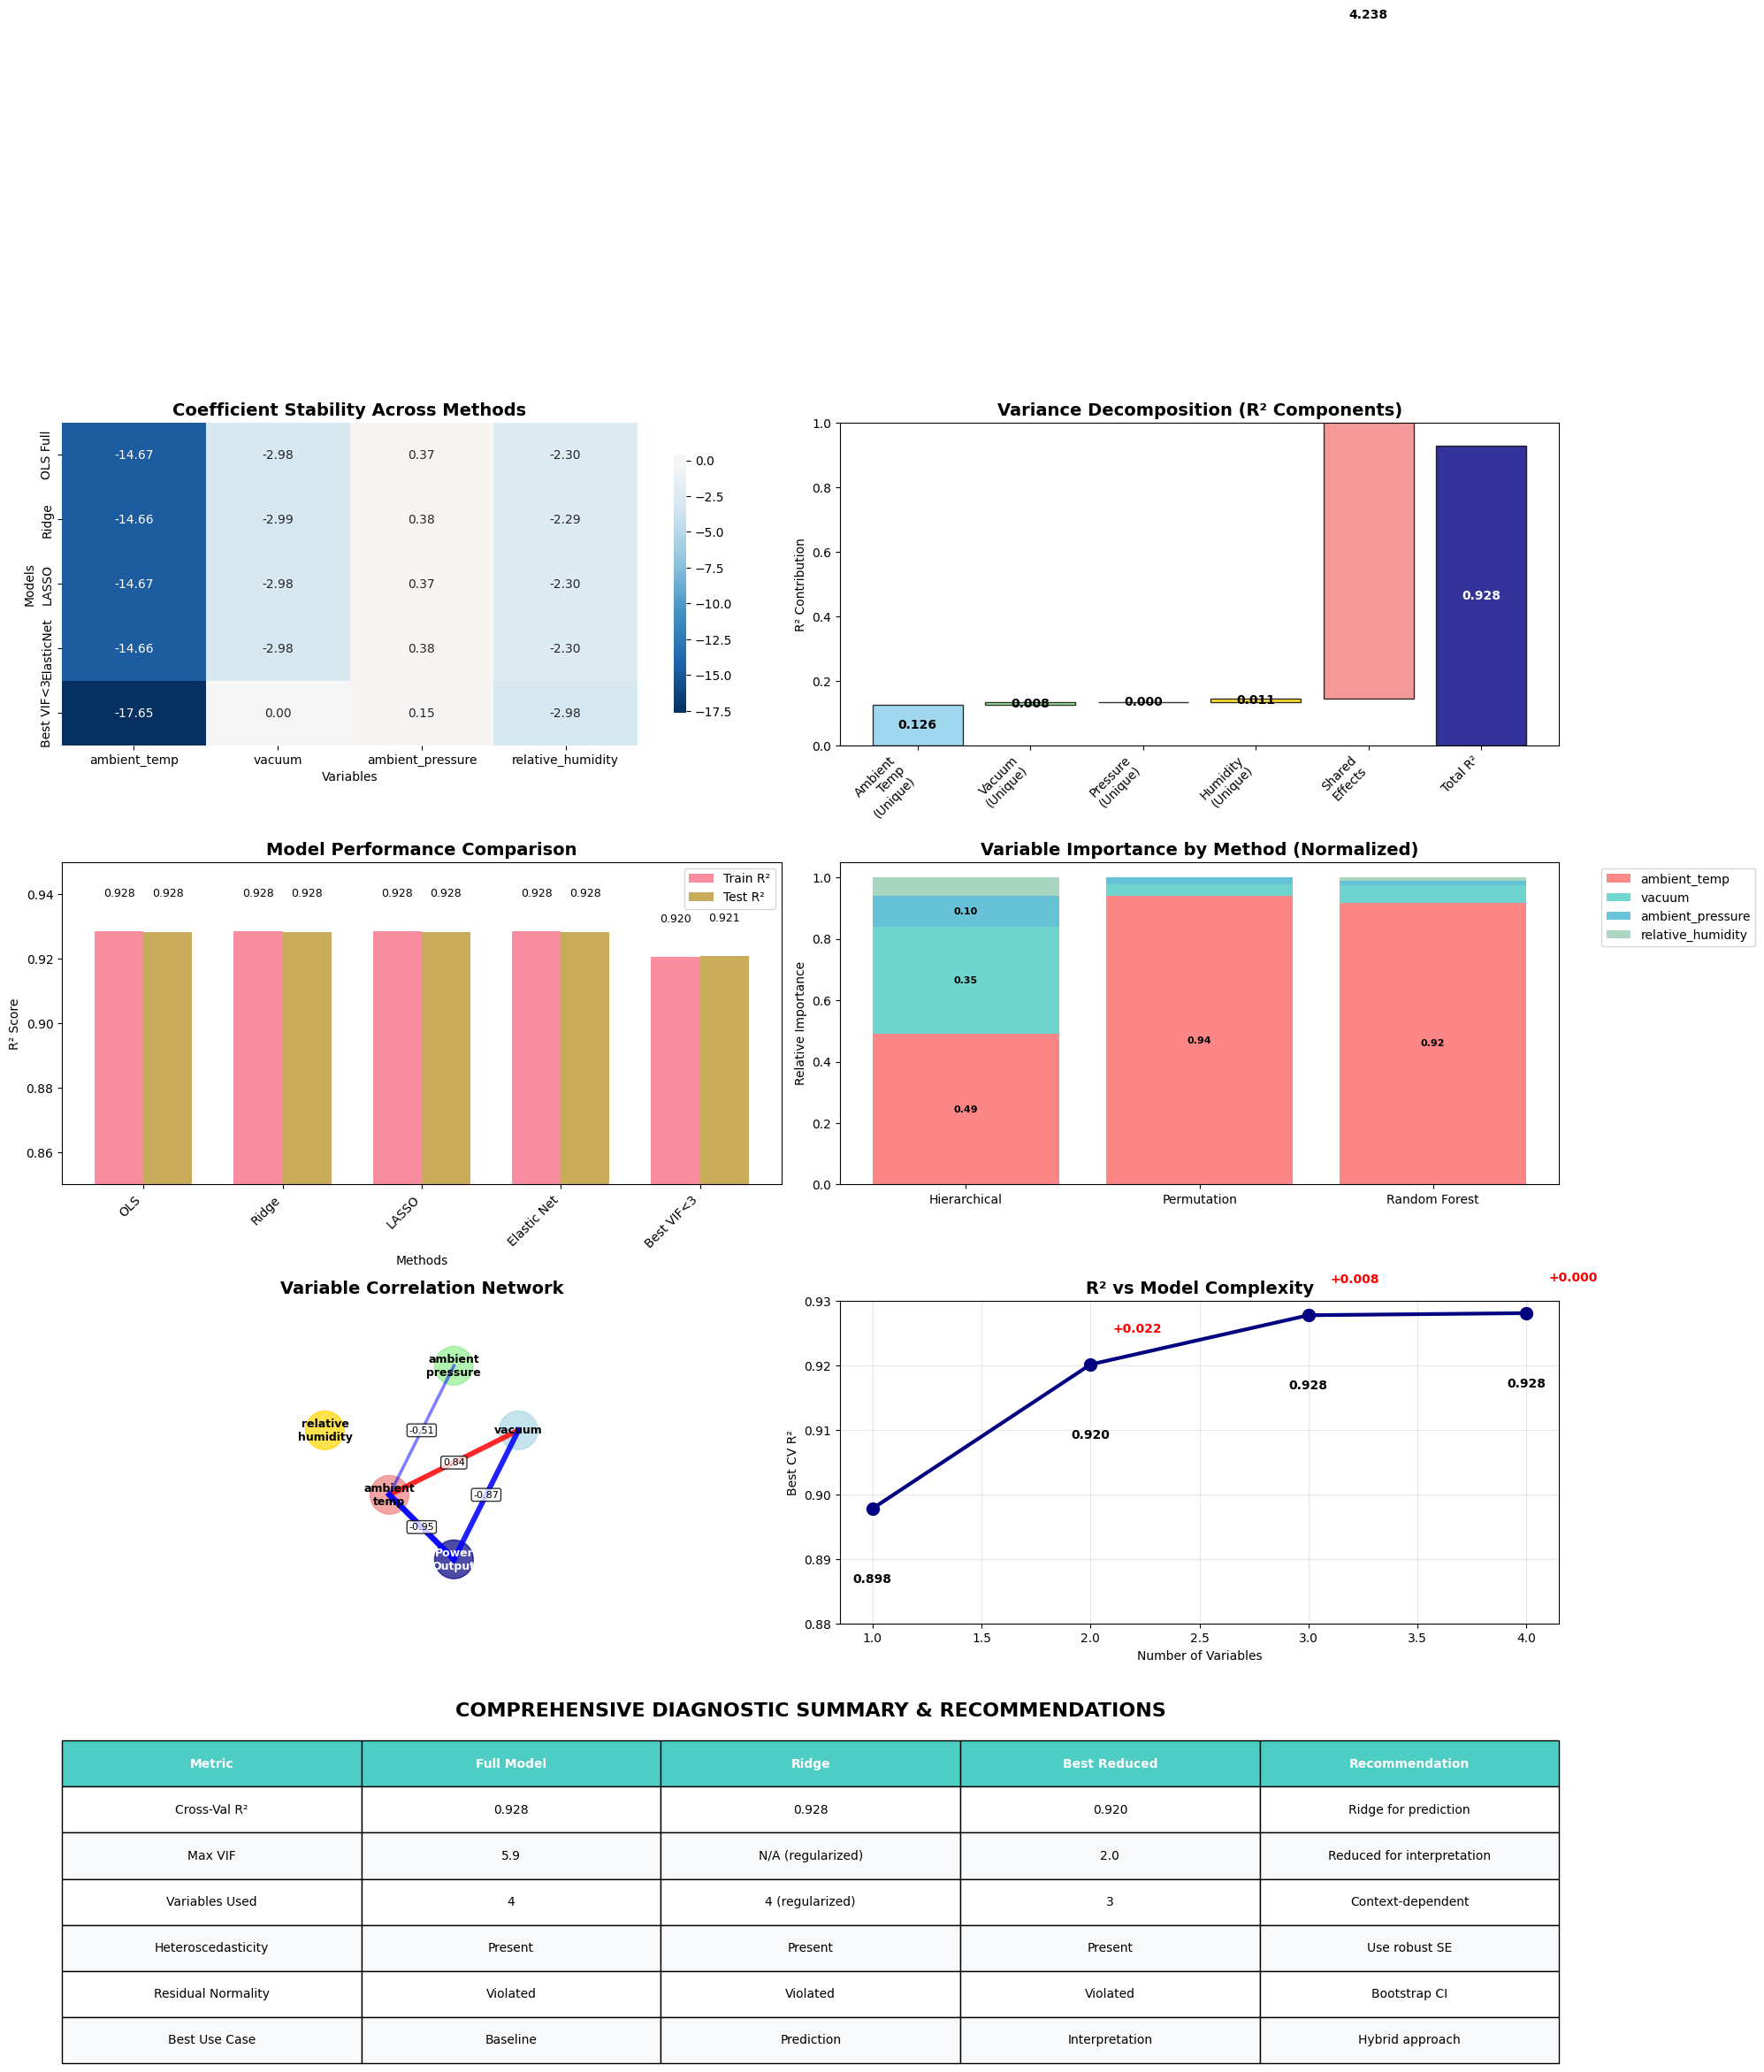


VARIABLE IMPORTANCE CONSENSUS:
1. ambient_temp        : Avg rank = 1.0
2. vacuum              : Avg rank = 2.0
3. ambient_pressure    : Avg rank = 3.3
4. relative_humidity   : Avg rank = 3.7


In [60]:
# PHASE 6: COMPREHENSIVE VISUALIZATIONS
# ======================================
# Professional visualizations summarizing all analysis phases

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')

# Set professional style
plt.style.use('default')
sns.set_palette("husl")

print("PHASE 6: COMPREHENSIVE VISUALIZATION SUITE")
print("=" * 50)

# Create figure for comprehensive analysis
fig = plt.figure(figsize=(20, 24))

# 1. COEFFICIENT STABILITY HEATMAP
print("Creating coefficient stability heatmap...")
ax1 = plt.subplot(4, 2, 1)

# Prepare coefficient data for heatmap
coef_data = []
model_names = []

# Add coefficients from key models
key_models = [
    ('OLS Full', ols_coefs),
    ('Ridge', ridge_coefs),
    ('LASSO', lasso_coefs),
    ('ElasticNet', enet_coefs)
]

for name, coefs in key_models:
    coef_data.append(coefs)
    model_names.append(name)

# Add best reduced model
best_reduced = results_df[results_df['Max_VIF'] < 3].nlargest(1, 'CV_R²').iloc[0]
best_reduced_model = None
for result in results_comprehensive:
    if result['feature_names'] == best_reduced['Features']:
        best_reduced_model = result
        break

if best_reduced_model:
    reduced_coefs = [best_reduced_model['coefficients'].get(f, {'coef': 0})['coef'] for f in features]
    coef_data.append(reduced_coefs)
    model_names.append('Best VIF<3')

# Create heatmap
coef_df = pd.DataFrame(coef_data, columns=features, index=model_names)
sns.heatmap(coef_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Coefficient Stability Across Methods', fontsize=14, fontweight='bold')
ax1.set_xlabel('Variables')
ax1.set_ylabel('Models')

# 2. VARIANCE DECOMPOSITION WATERFALL
print("Creating variance decomposition waterfall...")
ax2 = plt.subplot(4, 2, 2)

# Waterfall data
categories = ['Ambient\nTemp\n(Unique)', 'Vacuum\n(Unique)', 'Pressure\n(Unique)', 'Humidity\n(Unique)', 'Shared\nEffects', 'Total R²']
values = [
    unique_effects['ambient_temp'],
    unique_effects['vacuum'], 
    unique_effects['ambient_pressure'],
    unique_effects['relative_humidity'],
    total_shared,
    r2_full
]

# Create waterfall chart
cumulative = 0
colors = ['skyblue', 'lightgreen', 'coral', 'gold', 'lightcoral', 'navy']

for i, (cat, val) in enumerate(zip(categories[:-1], values[:-1])):
    ax2.bar(cat, val, bottom=cumulative, color=colors[i], alpha=0.8, edgecolor='black')
    # Add value labels
    ax2.text(i, cumulative + val/2, f'{val:.3f}', ha='center', va='center', fontweight='bold')
    cumulative += val

# Total bar
ax2.bar(categories[-1], values[-1], color=colors[-1], alpha=0.8, edgecolor='black')
ax2.text(len(categories)-1, values[-1]/2, f'{values[-1]:.3f}', ha='center', va='center', color='white', fontweight='bold')

ax2.set_title('Variance Decomposition (R² Components)', fontsize=14, fontweight='bold')
ax2.set_ylabel('R² Contribution')
ax2.set_ylim(0, 1.0)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. MODEL PERFORMANCE COMPARISON
print("Creating model performance comparison...")
ax3 = plt.subplot(4, 2, 3)

# Performance data
methods = ['OLS', 'Ridge', 'LASSO', 'Elastic Net', 'Best VIF<3']
train_r2s = [
    results_comprehensive[-1]['r2'],
    ridge_train_r2,
    lasso_train_r2, 
    enet_train_r2,
    best_reduced_model['r2'] if best_reduced_model else 0.9
]
test_r2s = [
    results_comprehensive[-1]['test_r2'],
    ridge_test_r2,
    lasso_test_r2,
    enet_test_r2,
    best_reduced_model['test_r2'] if best_reduced_model else 0.9
]

x = np.arange(len(methods))
width = 0.35

bars1 = ax3.bar(x - width/2, train_r2s, width, label='Train R²', alpha=0.8)
bars2 = ax3.bar(x + width/2, test_r2s, width, label='Test R²', alpha=0.8)

# Add value labels
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    ax3.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01, 
             f'{train_r2s[i]:.3f}', ha='center', va='bottom', fontsize=9)
    ax3.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.01,
             f'{test_r2s[i]:.3f}', ha='center', va='bottom', fontsize=9)

ax3.set_xlabel('Methods')
ax3.set_ylabel('R² Score')
ax3.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(methods, rotation=45, ha='right')
ax3.legend()
ax3.set_ylim(0.85, 0.95)

# 4. VARIABLE IMPORTANCE RANKINGS
print("Creating variable importance comparison...")
ax4 = plt.subplot(4, 2, 4)

# Importance rankings from different methods
importance_data = {
    'Hierarchical': [sorted_importance[0][1], sorted_importance[1][1], 
                    sorted_importance[2][1], sorted_importance[3][1]],
    'Permutation': [perm_results[0][1], perm_results[1][1], 
                   perm_results[2][1], perm_results[3][1]],
    'Random Forest': [rf_results[0][1], rf_results[1][1], 
                     rf_results[2][1], rf_results[3][1]]
}

# Normalize to same scale for comparison
for method in importance_data:
    total = sum(importance_data[method])
    importance_data[method] = [x/total for x in importance_data[method]]

# Create stacked bar chart
bottom_vals = np.zeros(len(features))
colors_imp = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, method in enumerate(importance_data.keys()):
    values = importance_data[method]
    ax4.bar(method, 1, color='lightgray', alpha=0.3)
    
    bottom = 0
    for j, (feature, val) in enumerate(zip(features, values)):
        ax4.bar(method, val, bottom=bottom, color=colors_imp[j], 
               label=feature if i == 0 else "", alpha=0.8)
        if val > 0.1:  # Only label if significant
            ax4.text(i, bottom + val/2, f'{val:.2f}', ha='center', va='center', 
                    fontsize=8, fontweight='bold')
        bottom += val

ax4.set_title('Variable Importance by Method (Normalized)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Relative Importance')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 5. CORRELATION NETWORK 
print("Creating correlation network diagram...")
ax5 = plt.subplot(4, 2, 5)

# Calculate positions for network diagram
pos_dict = {
    'ambient_temp': (0, 0),
    'vacuum': (1, 0.5),
    'ambient_pressure': (0.5, 1),
    'relative_humidity': (-0.5, 0.5),
    'power_output': (0.5, -0.5)
}

# Draw nodes
node_colors = ['lightcoral', 'lightblue', 'lightgreen', 'gold', 'navy']
node_sizes = [3000, 2500, 1500, 1000, 4000]  # Size by importance

for i, (var, pos) in enumerate(pos_dict.items()):
    color = node_colors[i] if var != 'power_output' else 'navy'
    size = node_sizes[i]
    circle = plt.Circle(pos, 0.15, color=color, alpha=0.7)
    ax5.add_patch(circle)
    
    # Add labels
    label = var.replace('_', '\n') if var != 'power_output' else 'Power\nOutput'
    ax5.text(pos[0], pos[1], label, ha='center', va='center', 
            fontsize=9, fontweight='bold', 
            color='white' if var == 'power_output' else 'black')

# Draw correlation edges
correlations = [
    ('ambient_temp', 'vacuum', 0.844),
    ('ambient_temp', 'ambient_pressure', -0.508),
    ('ambient_temp', 'relative_humidity', 0.140),
    ('ambient_temp', 'power_output', -0.948),
    ('vacuum', 'power_output', -0.870)
]

for var1, var2, corr in correlations:
    if abs(corr) > 0.3:  # Only show significant correlations
        pos1 = pos_dict[var1]
        pos2 = pos_dict[var2]
        
        # Line thickness based on correlation strength
        linewidth = abs(corr) * 5
        color = 'red' if corr > 0 else 'blue'
        alpha = abs(corr)
        
        ax5.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 
                color=color, linewidth=linewidth, alpha=alpha)
        
        # Add correlation labels
        mid_x, mid_y = (pos1[0] + pos2[0])/2, (pos1[1] + pos2[1])/2
        ax5.text(mid_x, mid_y, f'{corr:.2f}', ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                fontsize=8)

ax5.set_xlim(-1, 1.5)
ax5.set_ylim(-1, 1.5)
ax5.set_aspect('equal')
ax5.axis('off')
ax5.set_title('Variable Correlation Network', fontsize=14, fontweight='bold')

# 6. R² PROGRESSION ANALYSIS
print("Creating R² progression analysis...")
ax6 = plt.subplot(4, 2, 6)

# R² progression by number of variables
n_vars = [1, 2, 3, 4]
best_r2_by_nvars = []
for n in n_vars:
    best_model = results_df[results_df['N_Vars'] == n].nlargest(1, 'CV_R²').iloc[0]
    best_r2_by_nvars.append(best_model['CV_R²'])

# Plot progression
ax6.plot(n_vars, best_r2_by_nvars, 'o-', linewidth=3, markersize=10, color='navy')

# Add marginal improvements
for i in range(1, len(n_vars)):
    improvement = best_r2_by_nvars[i] - best_r2_by_nvars[i-1]
    ax6.annotate(f'+{improvement:.3f}', 
                xy=(n_vars[i], best_r2_by_nvars[i]), 
                xytext=(n_vars[i]+0.1, best_r2_by_nvars[i]+0.005),
                fontsize=10, fontweight='bold', color='red')

# Add values
for i, (n, r2) in enumerate(zip(n_vars, best_r2_by_nvars)):
    ax6.text(n, r2-0.01, f'{r2:.3f}', ha='center', va='top', 
            fontsize=10, fontweight='bold')

ax6.set_xlabel('Number of Variables')
ax6.set_ylabel('Best CV R²')
ax6.set_title('R² vs Model Complexity', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)
ax6.set_ylim(0.88, 0.93)

# 7. DIAGNOSTIC SUMMARY TABLE
print("Creating diagnostic summary...")
ax7 = plt.subplot(4, 1, 4)
ax7.axis('off')

# Create summary table
summary_data = [
    ['Metric', 'Full Model', 'Ridge', 'Best Reduced', 'Recommendation'],
    ['Cross-Val R²', f'{results_comprehensive[-1]["cv_r2_mean"]:.3f}', f'{ridge_test_r2:.3f}', 
     f'{best_reduced_model["cv_r2_mean"]:.3f}' if best_reduced_model else 'N/A', 'Ridge for prediction'],
    ['Max VIF', f'{results_comprehensive[-1]["max_vif"]:.1f}', 'N/A (regularized)', 
     f'{best_reduced_model["max_vif"]:.1f}' if best_reduced_model else 'N/A', 'Reduced for interpretation'],
    ['Variables Used', '4', '4 (regularized)', 
     f'{best_reduced_model["n_features"]}' if best_reduced_model else 'N/A', 'Context-dependent'],
    ['Heteroscedasticity', 'Present', 'Present', 'Present', 'Use robust SE'],
    ['Residual Normality', 'Violated', 'Violated', 'Violated', 'Bootstrap CI'],
    ['Best Use Case', 'Baseline', 'Prediction', 'Interpretation', 'Hybrid approach']
]

# Create table
table = ax7.table(cellText=summary_data[1:], colLabels=summary_data[0],
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Style the table
for i in range(len(summary_data[0])):
    table[(0, i)].set_facecolor('#4ECDC4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(summary_data)):
    for j in range(len(summary_data[0])):
        if j == len(summary_data[0]) - 1:  # Recommendation column
            table[(i, j)].set_facecolor('#FFE66D')
        table[(i, j)].set_facecolor('#F8F9FA' if i % 2 == 0 else 'white')

ax7.set_title('COMPREHENSIVE DIAGNOSTIC SUMMARY & RECOMMENDATIONS', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('images/comprehensive_ols_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVARIABLE IMPORTANCE CONSENSUS:")
print("=" * 30)
importance_ranking = []
for i, (var, _) in enumerate(sorted_importance):
    perm_rank = next(j for j, (f, _, _) in enumerate(perm_results, 1) if f == var)
    rf_rank = next(j for j, (f, _) in enumerate(rf_results, 1) if f == var)
    avg_rank = (i + 1 + perm_rank + rf_rank) / 3
    importance_ranking.append((var, avg_rank))

importance_ranking.sort(key=lambda x: x[1])

for rank, (var, avg_rank) in enumerate(importance_ranking, 1):
    print(f"{rank}. {var:20s}: Avg rank = {avg_rank:.1f}")
